In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

## Loading data

In [4]:
df = pd.read_csv("student_exam_data.csv")
df.head()

,Контрольная 1,Контрольная 2,Контрольная 3,Сон накануне,Настроение,Энергетиков накануне,Посещаемость занятий,Время подготовки,Сдал
0,4,4,9,Нет,Хорошее,4+,Низкая,За неделю,Нет
1,9,9,6,Да,Плохое,1,Средняя,Последний час,Да
2,8,6,9,Да,Хорошее,2-3,Средняя,Последний час,Да
3,8,4,9,Да,Хорошее,1,Высокая,Последняя ночь,Да
4,9,10,4,Нет,Нормальное,1,Низкая,Последний час,Да


## Data encoding

In [6]:
# Conversion of categorical data
categorical_cols = ["Сон накануне", "Настроение", "Энергетиков накануне", "Посещаемость занятий", "Время подготовки"]
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.astype('category').cat.codes)

In [7]:
# Target variable conversion
df["Сдал"] = df["Сдал"].map({"Нет": 0, "Да": 1})

## Optimization

In [9]:
# Generating new features
df["Средний балл"] = df[["Контрольная 1", "Контрольная 2", "Контрольная 3"]].mean(axis=1)
df["Сумма баллов"] = df[["Контрольная 1", "Контрольная 2", "Контрольная 3"]].sum(axis=1)
df["Эффективность_подготовки"] = df["Сумма баллов"] / (df["Время подготовки"] + 1)


## Model creation

In [11]:
# Разделение данных на обучающую и тестовую выборки
X = df.drop(columns=["Сдал"])
y = df["Сдал"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Нормализация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Обучение XGBoost
model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [14]:
import joblib

joblib.dump(model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## Accuracy assessment

In [16]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [17]:
print(f"Model accuracy: {accuracy * 100:.2f}%")

Model accuracy: 96.67%


## Useful information and graphics

In [18]:
# Significance analysis
importances = pd.Series(model.feature_importances_, index=X.columns)
print("Важность признаков:")
print(importances.sort_values(ascending=False).head(5))

Важность признаков:
Средний балл            0.249227
Сон накануне            0.233347
Энергетиков накануне    0.194198
Посещаемость занятий    0.085792
Время подготовки        0.065840
dtype: float32


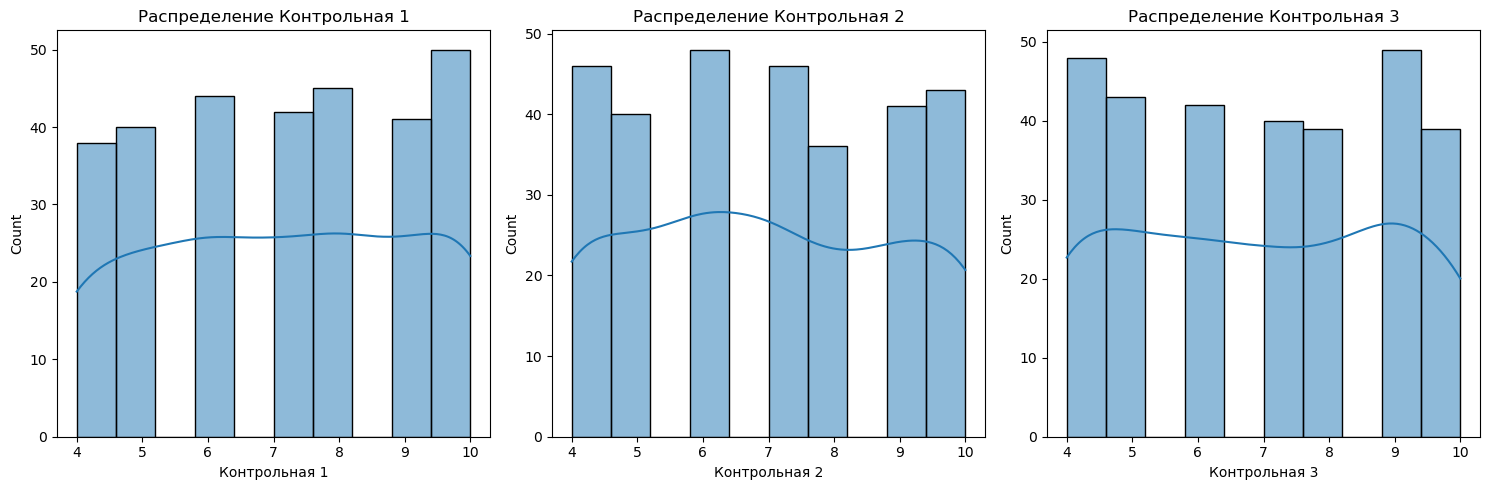

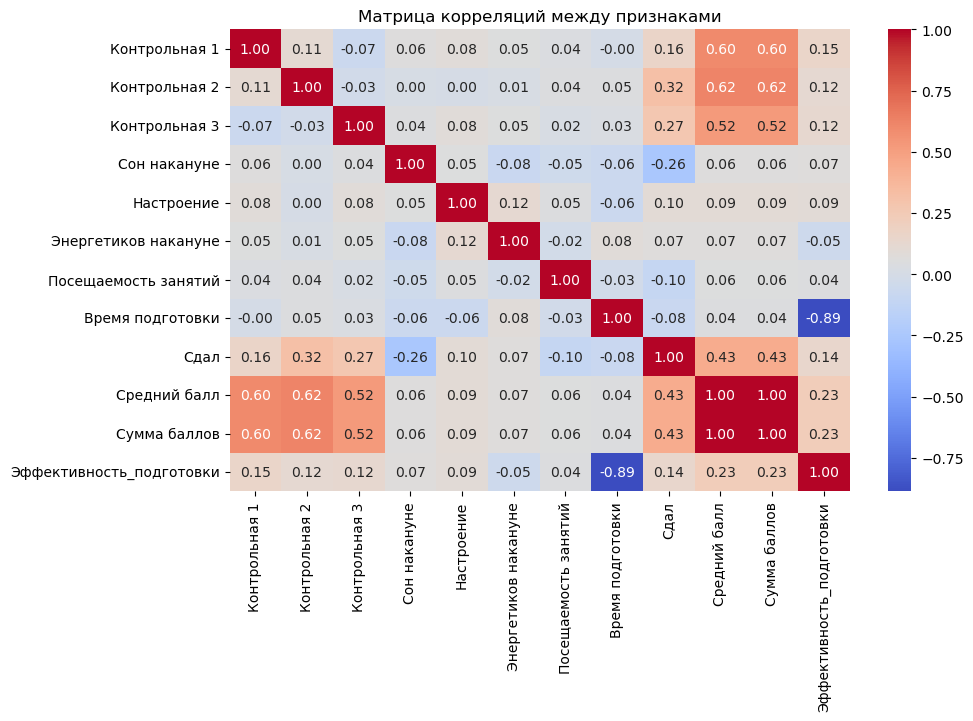

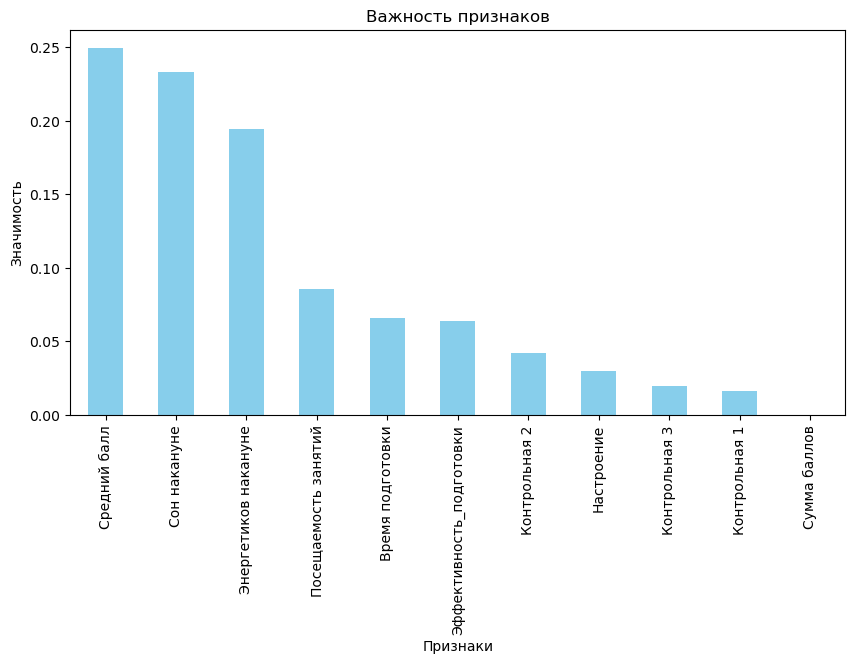

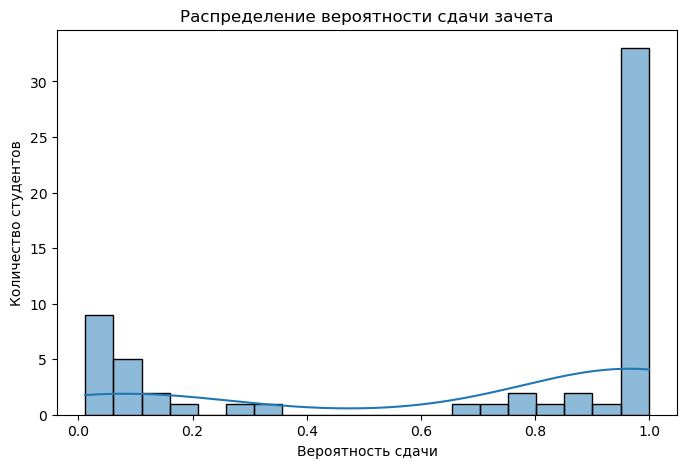

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Распределение оценок за контрольные
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(["Контрольная 1", "Контрольная 2", "Контрольная 3"]):
    sns.histplot(df[col], bins=10, kde=True, ax=axes[i])
    axes[i].set_title(f"Распределение {col}")

plt.tight_layout()
plt.show()

# 2. Корреляционная матрица
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций между признаками")
plt.show()

# 3. Важность признаков
importances.sort_values(ascending=False).plot(kind="bar", figsize=(10, 5), color="skyblue")
plt.title("Важность признаков")
plt.xlabel("Признаки")
plt.ylabel("Значимость")
plt.show()


# 5. Распределение вероятности сдачи
y_pred_proba = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 5))
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.title("Распределение вероятности сдачи зачета")
plt.xlabel("Вероятность сдачи")
plt.ylabel("Количество студентов")
plt.show()
